In [1]:
from spacy.lang.en import English
from time import perf_counter as timer
import json
import re
import random
import torch
import numpy as np
import pandas as pd
import textwrap
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import networkx as nx
from pyvis.network import Network
from IPython.display import display, HTML

In [2]:
config_params = [0, 2, 1]

# RAG

In [3]:
df_init = pd.read_csv('../Analisis/Data/scopus.csv')
df_init = df_init[df_init['Document Type'].isin(['Article', 'Conference paper'])].reset_index(drop=True)
print("Cantidad =", len(df_init))
print('Repetidos =', df_init.duplicated().sum())
print("Nulos :")
print(df_init[['Title', 'Abstract']].isna().sum())

Cantidad = 9164
Repetidos = 0
Nulos :
Title       0
Abstract    0
dtype: int64


In [4]:
#df = pd.read_csv("DF_Journals.csv")
#df['Abstract'] = df['Abstract'].str.split('©').str[0]
df = df_init[["Abstract"]].copy()

In [5]:
#df['Word_Count'] = df['Abstract'].apply(lambda x: len(str(x).split()))
#filtered_df = df[df['Word_Count'] > 384]
#filtered_df

In [6]:
rows_dict = {}
with open("config.txt", "r") as file:
    for i, line in enumerate(file):
        rows_dict[f"row_{i+1}"] = line.strip()
for key, value in rows_dict.items():
    print(f"{key}: {value}")
llms_conf = rows_dict["row_1"]
llms_conf = json.loads(llms_conf)
prompts_conf = rows_dict["row_2"]
prompts_conf = json.loads(prompts_conf)
embeddings_conf = rows_dict["row_3"]
embeddings_conf = json.loads(embeddings_conf)

row_1: ["meta-llama/Llama-3.2-3B-Instruct","Qwen/Qwen2.5-3B-Instruct","meta-llama/Llama-3.1-8B-Instruct","google/gemma-2b-it"]
row_2: [["Based on the following context items, please consider the ranked documents you retrieved to answer the query in the form of an abstract for a poposed work/investigation/tesis. Give yourself room to think by extracting relevant passages from the context before answering the query. Don't return the thinking or the title, only return the abstract of the proposed work. \nNow use the following context items to answer the user query: {context} \nRelevant passages: <extract relevant passages from the context here> User query: {query}\nAnswer: "],["Instruct: Given a query, retrieve relevant passages that answer the query in the form of an abstract for a poposed work/investigation/thesis. Just return the abstract, nothing more.\nContext: {context}\nQuery: {query}"], ["Context information is below.n---------------------n{context}\n---------------------\nGiven t

In [7]:
embedding_model = SentenceTransformer(model_name_or_path=embeddings_conf[config_params[2]], trust_remote_code=True, device="cuda")

README.md:   0%|          | 0.00/170k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/dunzhang/stella_en_400M_v5:
- configuration.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/dunzhang/stella_en_400M_v5:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Some weights of the model checkpoint at dunzhang/stella_en_400M_v5 were not used when initializing NewModel: ['new.pooler.dense.bias', 'new.pooler.dense.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from t

In [8]:
sentences = df['Abstract'].tolist()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))
embedding_df = pd.DataFrame({
    'Abstract': sentences,
    'Embedding': list(embeddings)
})

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
pages_and_chunks = embedding_df.to_dict(orient="records")
embeddings = torch.tensor(np.array(embedding_df["Embedding"].tolist()), dtype=torch.float32).to(device)
#embeddings.shape

In [10]:
llm_model = AutoModelForCausalLM.from_pretrained(llms_conf[config_params[0]],
#                                             torch_dtype=torch.float16,
                                             low_cpu_mem_usage=True)
llm_model.to(device)
tokenizer = AutoTokenizer.from_pretrained(llms_conf[config_params[0]])
tokenizer.pad_token_id=tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

3212749824

In [12]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.
    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])
    model_mem_bytes = mem_params + mem_buffers
    model_mem_mb = model_mem_bytes / (1024**2)
    model_mem_gb = model_mem_bytes / (1024**3)
    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 12851006720,
 'model_mem_mb': 12255.68,
 'model_mem_gb': 11.97}

In [13]:
gpt4_questions = [
    "What are the primary stages in mineral processing, and what purpose does each stage serve?",
    "How does comminution contribute to the effectiveness of mineral processing, and what techniques are commonly used in this stage?",
    "What role do froth flotation and other separation processes play in mineral beneficiation, and how do they differ?",
    "How is particle size analysis conducted in mineral processing, and why is it important for downstream processes?",
    "Explain the main factors that influence the efficiency of gravity separation in mineral processing.",
    "Explain the differences between pyrometallurgical and hydrometallurgical processing methods, and when each is preferred.",
    "What environmental considerations must be taken into account in the design and operation of mineral processing facilities?",
    "How does magnetic separation work, and in what situations is it most effectively applied in mineral processing?",
    "What are tailings, and what are the challenges associated with their management in the mineral processing industry?",
    "How is process optimization achieved in mineral processing plants, and what key performance indicators (KPIs) are typically monitored?"
]
query_list = gpt4_questions

In [14]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    context = "- " + "\n- ".join([item["Abstract"] for item in context_items])
    base_prompt = prompts_conf[config_params[1]][0]
    #print(base_prompt)
    base_prompt = base_prompt.format(context=context, query=query)
    #print(base_prompt)
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [15]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=10,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """
    query_embedding = model.encode(query, convert_to_tensor=True)
    start_time = timer()
    if config_params[2]==0:
        dot_scores = util.dot_score(query_embedding, embeddings)[0]
    else:
        dot_scores = util.cos_sim(query_embedding, embeddings)[0]
    end_time = timer()
    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")
    scores, indices = torch.topk(input=dot_scores, k=n_resources_to_return)
    return scores, indices

In [16]:
def ask(query,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """
    scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)
    context_items = [pages_and_chunks[i] for i in indices]
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu()
    prompt = prompt_formatter(query=query,
                              context_items=context_items)
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")
    if return_answer_only:
        return output_text

    return output_text, context_items

In [17]:
def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [18]:
query = "What are tailings, and what are the challenges associated with their management in the mineral processing industry?"
print(f"Query: {query}")
answer, context_items = ask(query, return_answer_only=False)
print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Query: What are tailings, and what are the challenges associated with their management in the mineral processing industry?
[INFO] Time taken to get scores on 9164 embeddings: 0.00693 seconds.
Answer:

<|begin_of_text|>Title: Challenges and Opportunities in Tailings Management in
the Mineral Processing Industry: A Review of Environmental, Economic, and
Technological Aspects  Abstract:  Tailings, the waste materials generated during
mineral processing, pose significant environmental, economic, and technological
challenges for the mineral processing industry. The increasing volume of
tailings, coupled with the growing demand for metals, has led to a pressing need
for sustainable and efficient tailings management practices. This study aims to
review the current state of tailings management in the mineral processing
industry, highlighting the environmental, economic, and technological challenges
associated with tailings disposal and utilization. The review will focus on the
environmental im

[{'Abstract': 'Introduction. At enterprises engaged in the extraction and processing of mineral raw materials, the volume of production waste is usually much higher than the volume of a commercial product. At the same time, there is a tendency to decrease the metal content in ores while increasing the volume of waste rock extracted when accessing ores. According to various estimates, the annual volume of waste from mining enterprises is 7 billion tons per year. The proportion of waste (tailings) in some copper-containing ores can reach 98 % or higher. Gold mining enterprises process ores in which tailings amount to 99.9 % and which contain only a few grams of gold. This trend will continue, as the enterprises of the mineral processing industry have to increase the volume of processed products. Materials and methods. Tailings processing technology solutions include equipment and services that can be used in almost any tailings farm, while tailings thickening and paste thickening can be 

# Knowledge Graph

In [19]:
print(f"Number of texts extracted: {len(context_items)}")

Number of texts extracted: 10


In [20]:
# Define a cosine similarity function optimized for PyTorch tensors
def cosine_similarity_pytorch(matrix):
    """
    Computes pairwise cosine similarity for a given matrix of vectors.
    
    Args:
        matrix (torch.Tensor): A 2D tensor where each row is a vector.
    
    Returns:
        torch.Tensor: A 2D tensor containing cosine similarity scores.
    """
    # Compute the dot product of each vector with all others
    dot_products = torch.mm(matrix, matrix.T)
    # Compute the L2 norm for each vector
    norms = torch.norm(matrix, dim=1, keepdim=True)
    # Compute the outer product of norms
    norm_products = torch.mm(norms, norms.T)
    # Return cosine similarity scores
    return dot_products / norm_products

pd.options.display.float_format = '{:.6f}'.format  # Display values with six decimal places

# Step 1: Extract abstracts from the provided list
abstracts_from_list = [item['Abstract'] for item in context_items]

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()
similar_abstracts = []

for idx, list_abstract in enumerate(abstracts_from_list):
    # Crear un corpus con el abstract actual y los del DataFrame
    corpus = [list_abstract] + df['Abstract'].tolist()
    
    # Transformar el corpus en una matriz TF-IDF dispersa
    tfidf_matrix = vectorizer.fit_transform(corpus)
    
    # Mantener la matriz como dispersa
    tfidf_tensor_sparse = torch.tensor(tfidf_matrix.toarray(), dtype=torch.float32)
    
    # Normalizar los vectores
    norms = torch.norm(tfidf_tensor_sparse, dim=1, keepdim=True)
    normalized_tensors = tfidf_tensor_sparse / norms

    # Calcular similitudes coseno usando matrices densas en la CPU
    similarity_matrix = torch.mm(normalized_tensors, normalized_tensors.T)

    # Extraer similitudes para el vector base
    base_similarities = similarity_matrix[0, 1:]
    similar_indices = torch.where(base_similarities > 0.95)[0]
    
    for i in similar_indices.numpy():
        similar_abstracts.append({
            "Title": f"Text{idx + 1}",
            "Abstract": df.iloc[i]['Abstract'],
            "Similarity": base_similarities[i].item()
        })


# Convert the results to a DataFrame
result_df = pd.DataFrame(similar_abstracts)

# Display the results
result_df

,Title,Abstract,Similarity
0,Text1,Introduction. At enterprises engaged in the ex...,1.000000
1,Text2,"Increasing population levels, growing economie...",1.000000
2,Text3,During the extraction of nuclear raw materials...,1.000000
3,Text4,The paper deals with a pressing issue of the e...,1.000000
4,Text5,The quest for steady primary supplies of criti...,1.000000
5,Text6,Tailings seem to be the materials left over af...,1.000000
6,Text7,The vast amount of waste produced by the minin...,1.000000
7,Text8,Intensive development of the mining and metall...,1.000000
8,Text9,Introduction. In an era of economic transnatio...,1.000000
9,Text10,One of the key problems of mining production i...,1.000000


In [21]:
# Usar una expresión regular para extraer el contenido entre las etiquetas
match = re.search(r"<\|begin_of_text\|>(.*?)<\|eot_id\|>", answer, re.DOTALL)
if match:
    new_text = match.group(1).strip()
    print(new_text)
else:
    print("No se encontró texto entre las etiquetas.")

new_title = 'Artificial'

Title: Challenges and Opportunities in Tailings Management in the Mineral Processing Industry: A Review of Environmental, Economic, and Technological Aspects

Abstract:

Tailings, the waste materials generated during mineral processing, pose significant environmental, economic, and technological challenges for the mineral processing industry. The increasing volume of tailings, coupled with the growing demand for metals, has led to a pressing need for sustainable and efficient tailings management practices. This study aims to review the current state of tailings management in the mineral processing industry, highlighting the environmental, economic, and technological challenges associated with tailings disposal and utilization. The review will focus on the environmental impacts of tailings, including water and soil pollution, and the economic benefits of tailings reuse and recycling. Additionally, the study will explore the technological advancements in tailings management, including sl

In [22]:
# Download necessary resources
nltk.download('punkt', force=True)
nltk.download('stopwords', force=True)
nltk.download('wordnet', force=True)
nltk.download('omw-1.4', force=True)

# Assume you have a DataFrame called `result_df`
df_original_token = result_df[['Title', 'Abstract']].copy()

# Ensure there are no null values in the 'Abstract' column
df_original_token['Abstract'] = df_original_token['Abstract'].fillna("")

# Create a list of stopwords in English
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to process text
def process_text(text):
    # Tokenization
    tokens = word_tokenize(text.lower())  # Convert to lowercase
    # Lemmatization, filter stopwords and punctuation
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word not in string.punctuation]
    return processed_tokens

# Apply the function to the 'Abstract' column
df_original_token['Tokens'] = df_original_token['Abstract'].apply(process_text)

# View the first results
df_original_token


[nltk_data] Downloading package punkt to /home/jupyter-
[nltk_data]     lucay/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/jupyter-
[nltk_data]     lucay/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/jupyter-
[nltk_data]     lucay/nltk_data...
[nltk_data] Downloading package omw-1.4 to /home/jupyter-
[nltk_data]     lucay/nltk_data...


,Title,Abstract,Tokens
0,Text1,Introduction. At enterprises engaged in the ex...,"[introduction, enterprise, engaged, extraction..."
1,Text2,"Increasing population levels, growing economie...","[increasing, population, level, growing, econo..."
2,Text3,During the extraction of nuclear raw materials...,"[extraction, nuclear, raw, material, rare, ear..."
3,Text4,The paper deals with a pressing issue of the e...,"[paper, deal, pressing, issue, environmental, ..."
4,Text5,The quest for steady primary supplies of criti...,"[quest, steady, primary, supply, critical, raw..."
5,Text6,Tailings seem to be the materials left over af...,"[tailing, seem, material, left, separation, pr..."
6,Text7,The vast amount of waste produced by the minin...,"[vast, amount, waste, produced, mining, indust..."
7,Text8,Intensive development of the mining and metall...,"[intensive, development, mining, metallurgical..."
8,Text9,Introduction. In an era of economic transnatio...,"[introduction, era, economic, transnationalisa..."
9,Text10,One of the key problems of mining production i...,"[one, key, problem, mining, production, involv..."


In [23]:
def Natural_connectivity(graph):#https://arxiv.org/pdf/2105.00419    http://dx.doi.org/10.1016/j.physa.2017.01.0720
    L  = nx.adjacency_spectrum(graph)
    L1 = sum(np.exp(np.real(L[i])) for i in range(graph.number_of_nodes()))
    return np.log(L1/graph.number_of_nodes())/(graph.number_of_nodes() - np.log(graph.number_of_nodes()))    
   
def Conductance(graph): #hhttp://dx.doi.org/10.1016/j.physa.2017.01.072
    L     = nx.laplacian_matrix(graph)
    eig   = np.round(np.linalg.eigvals(L.toarray()),5)
    N     = graph.number_of_nodes() 
    S     = 0
    for i in range(len(eig)):
        if np.real(eig[i])!=0:
            S = S + 1/np.real(eig[i])
    return (N-1)/(N*S)

def SpectralRadius(graph):
    adj = nx.adjacency_matrix(graph)
    eig = np.linalg.eigvalsh(adj.toarray())
    spec =  np.max(np.abs(eig))
    degrees = dict(graph.copy().degree())
    max_degree  = max(degrees.values())
    min_degree  = min(degrees.values())
    m = nx.number_of_edges(graph.copy())
    n = nx.number_of_nodes(graph.copy())
    bound = (2*m - min_degree*n + max_degree*min_degree - max_degree + min_degree)**0.5
    return spec/bound
    
def SpectralGap(graph):
    L     = nx.laplacian_matrix(graph)
    eig   = np.round(np.linalg.eigvals(L.toarray()),5)
    N     = nx.number_of_nodes(graph.copy())
    return np.real(eig[0] - eig[1])/N

def AverageDegree(graph):
    N = nx.number_of_nodes(graph.copy())
    return (sum(dict(graph.degree()).values())/N)/(N-1)

def AverageEdgeBetweenness(graph): #vulnerability of complex networks Igor mishkovski
    N  = nx.number_of_nodes(graph.copy())
    return (1/nx.average_shortest_path_length(graph) - 1)/(6/(N*(N+1)) - 1)

def calculate_metrics(graph):
    metrics = {}
    # Connectivity
    metrics['Global Efficiency']              = nx.global_efficiency(graph) # max
    metrics['Average Degree']                 = AverageDegree(graph) # max
    metrics['Average Edge Betweenness']       = AverageEdgeBetweenness(graph)# max
    # Adjacency Matrix Spectrum
    metrics['Spectral Radius']                = SpectralRadius(graph) # max
    metrics['Spectral Gap']                   = SpectralGap(graph) # max
    metrics['Natural Connectivity']           = Natural_connectivity(graph) # max
    # Laplacian Matrix Spectrum
    metrics['Algebra Connectivity']           = nx.algebraic_connectivity(graph)/graph.number_of_nodes() #max
    metrics['Conductance']                    = Conductance(graph) # max
    return metrics

In [24]:
#calculate_metrics(filtered_graph) #generar spider y determinar área para comparsión

In [25]:
#!pip install pyvis

In [26]:
# Function to plot the interactive graph and save it as an HTML file
def plot_interactive_graph_colab(graph, filename="graph.html"):
    # Compute node positions using NetworkX
    pos = nx.spring_layout(graph)  # You can replace this with another layout like nx.circular_layout(graph)

    # Create PyVis graph
    net = Network(height="750px", width="100%", bgcolor="#ffffff", font_color="black", cdn_resources="in_line")

    # Add nodes with precomputed positions
    for node, data in graph.nodes(data=True):
        x, y = pos[node]  # Get the position of the node
        net.add_node(
            node,
            title=f"Word: {node}",
            color=data.get('color', 'blue'),  # Default to blue if no color is specified
            x=x * 1000,  # Scale positions for PyVis
            y=y * 1000,
            label=""  # Hide labels if desired
        )

    # Add edges
    for source, target in graph.edges():
        net.add_edge(source, target)

    # Disable physics
    net.set_options("""
    {
        "physics": {
            "enabled": false
        }
    }
    """)

    filename = f"Graphs/{filename}"
    
    # Save the HTML file
    net.save_graph(filename)

    # Display the graph directly in the notebook or environment
    with open(filename, "r") as f:
        display(HTML(f.read()))


In [27]:
# Create the graph
G = nx.Graph()

# Add nodes for titles (in red) and connections with tokens
for index, row in df_original_token.iterrows():
    title = row['Title']
    tokens = row['Tokens']

    # Add the title node
    G.add_node(title, color='red', type='title')

    # Add nodes for tokens and connect them to the title
    for token in tokens:
        if not G.has_node(token):  # Avoid duplicate nodes for tokens
            G.add_node(token, color='blue', type='token')
        G.add_edge(title, token)  # Connect the token to the title

# Filter nodes with more than one edge
nodes_to_keep = [node for node, degree in G.degree() if degree > 1]
filtered_graph = G.subgraph(nodes_to_keep).copy()

# Extract colors of the nodes
node_colors = [filtered_graph.nodes[node]['color'] for node in filtered_graph.nodes]

# Plot the graph interactively
plot_interactive_graph_colab(filtered_graph, f"Graph_Before_{config_params[0]}{config_params[1]}{config_params[2]}.html")

# Calculate metrics for the filtered graph (optional)
metrics_before = calculate_metrics(filtered_graph)
betweenness_before = nx.betweenness_centrality(filtered_graph)


In [28]:
# Function to add new text to the graph
def add_new_text(graph, title, text, stop_words):
    # Tokenize and filter the new text
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words and word not in string.punctuation]

    # Add the title node
    graph.add_node(title, color="red", type="title")

    # Add nodes for the tokens and connect them to the title
    for token in filtered_tokens:
        if not graph.has_node(token):  # If the token doesn't exist, add it
            graph.add_node(token, color="blue", type="token")
        graph.add_edge(title, token)  # Connect the token to the title

# Call the function to add the new text
add_new_text(G, new_title, new_text, stop_words)

# Filter nodes with more than one edge
nodes_to_keep = [node for node, degree in G.degree() if degree > 1]
filtered_graph = G.subgraph(nodes_to_keep).copy()

# Plot the updated and filtered graph
plt.figure(figsize=(12, 8))
plot_interactive_graph_colab(filtered_graph, f"Graph_After_{config_params[0]}{config_params[1]}{config_params[2]}.html")

# Calculate metrics for the filtered graph
metrics_after = calculate_metrics(filtered_graph)
betweenness_after = nx.betweenness_centrality(filtered_graph)

<Figure size 1200x800 with 0 Axes>

In [29]:
df_metrics = pd.DataFrame([metrics_before, metrics_after], index=["Before", "After"])

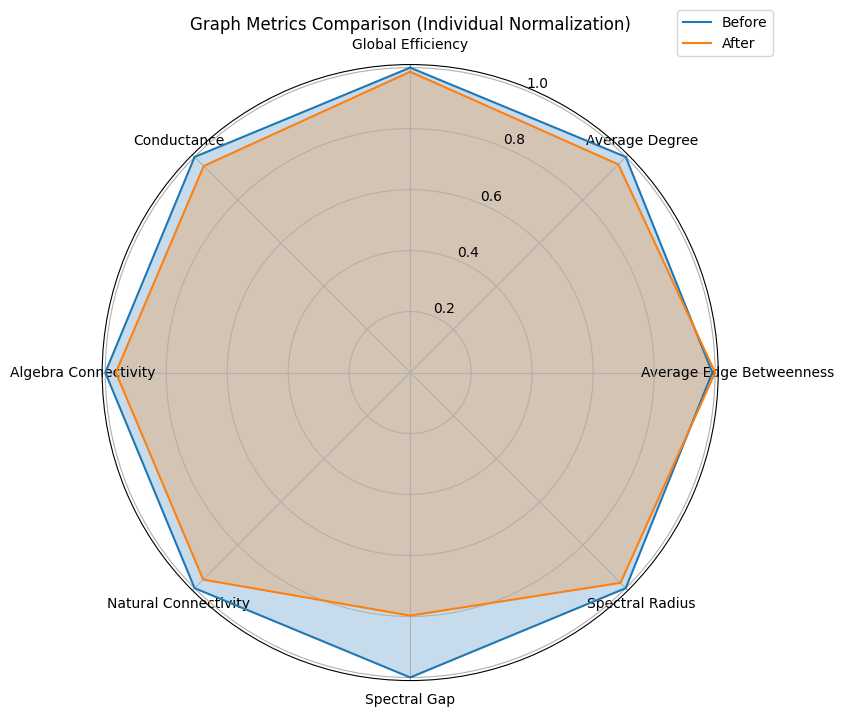

Área Before: 2.822009172506454
Área After: 2.5572765434900697


In [30]:
# Normalization by individual metric
def normalize_by_metric(metrics_before, metrics_after):
    normalized_before = []
    normalized_after = []
    for key in metrics_before.keys():
        maximum = max(metrics_before[key], metrics_after[key])
        if maximum > 0:  # Avoid division by zero
            normalized_before.append(metrics_before[key] / maximum)
            normalized_after.append(metrics_after[key] / maximum)
        else:
            normalized_before.append(0)
            normalized_after.append(0)
    return normalized_before, normalized_after

# Apply normalization by metric
metrics_before_norm, metrics_after_norm = normalize_by_metric(metrics_before, metrics_after)

# Close the data for the radar chart
metrics_before_norm += metrics_before_norm[:1]
metrics_after_norm += metrics_after_norm[:1]

angles = np.linspace(0, 2 * np.pi, len(metrics_before) + 1, endpoint=True)

# Create the radar chart with individually normalized metrics
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

ax.plot(angles, metrics_before_norm, label='Before', linestyle='solid')
ax.fill(angles, metrics_before_norm, alpha=0.25)

ax.plot(angles, metrics_after_norm, label='After', linestyle='solid')
ax.fill(angles, metrics_after_norm, alpha=0.25)

# Configure labels
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), list(metrics_before.keys()))

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.title("Graph Metrics Comparison (Individual Normalization)")

# Save the figure
output_filename = f"Graphs/Graph_spiderWeb_metrics_comparison_{config_params[0]}{config_params[1]}{config_params[2]}.png"
plt.savefig(output_filename, dpi=300, bbox_inches='tight')  # Save with high resolution

# Show the chart
plt.show()

def calculate_radar_area(values, angles):
    n = len(values)
    area = 0.5 * np.abs(
        sum(values[i] * values[i + 1] * np.sin(angles[i + 1] - angles[i]) for i in range(n - 1))
    )
    return area

# Cálculo de áreas
area_before = calculate_radar_area(metrics_before_norm, angles)
area_after = calculate_radar_area(metrics_after_norm, angles)

print("Área Before:", area_before)
print("Área After:", area_after)



In [31]:
df_metrics

,Global Efficiency,Average Degree,Average Edge Betweenness,Spectral Radius,Spectral Gap,Natural Connectivity,Algebra Connectivity,Conductance
Before,0.422199,0.024461,0.626361,0.535437,0.083399,0.048855,0.005818,0.011107
After,0.416491,0.023617,0.632098,0.522299,0.066481,0.046914,0.005616,0.010639


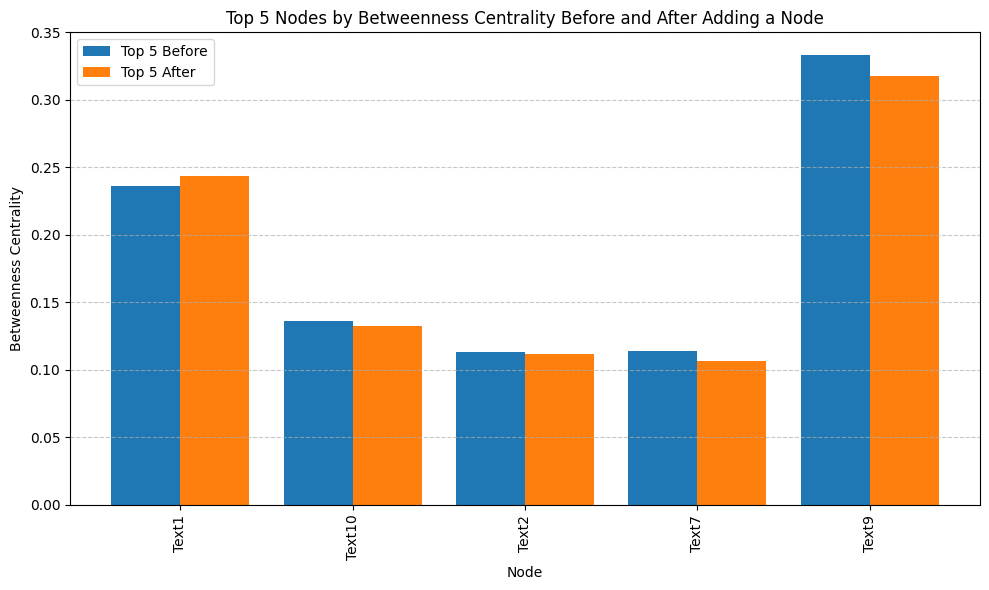

In [32]:
# Create the plot with labels rotated at 90°
plt.figure(figsize=(10, 6))
width = 0.4  # Width of the bars

# Get the top 5 nodes with the highest betweenness centrality before and after
top_5_before = sorted(betweenness_before.items(), key=lambda x: x[1], reverse=True)[:5]
top_5_after = sorted(betweenness_after.items(), key=lambda x: x[1], reverse=True)[:5]

# Convert the results to a DataFrame for easier plotting
df_before = pd.DataFrame(top_5_before, columns=['Node', 'Betweenness'])
df_before['State'] = 'Before'

df_after = pd.DataFrame(top_5_after, columns=['Node', 'Betweenness'])
df_after['State'] = 'After'

# Combine both DataFrames
df = pd.concat([df_before, df_after])

# Create a range of numeric indices to avoid type issues
nodes = sorted(df['Node'].unique())
x_indices = np.arange(len(nodes))  # Numeric indices for the nodes

for state, offset in zip(['Before', 'After'], [-width / 2, width / 2]):
    subset = df[df['State'] == state]
    # Map nodes to indices
    subset_x = [x_indices[nodes.index(node)] for node in subset['Node']]
    plt.bar(
        np.array(subset_x) + offset,  # Offset to distinguish bars
        subset['Betweenness'],
        width=width,
        label=f'Top 5 {state}',
    )

# Configure labels and legends
plt.xlabel('Node')
plt.ylabel('Betweenness Centrality')
plt.title('Top 5 Nodes by Betweenness Centrality Before and After Adding a Node')
plt.xticks(x_indices, nodes, rotation=90)  # Rotate labels to 90°
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the figure
output_filename = f"Graphs/top_5_betweenness_centrality_{config_params[0]}{config_params[1]}{config_params[2]}.png"  # Replace with your desired filename
plt.savefig(output_filename, dpi=300, bbox_inches='tight')  # Save with high resolution

# Show the chart
plt.show()


In [33]:
# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(filtered_graph)

# Find the node with the highest betweenness centrality
max_centrality_node = max(betweenness_centrality, key=betweenness_centrality.get)
max_centrality_value = betweenness_centrality[max_centrality_node]

# Print the result
print(f"Node with the highest betweenness centrality: {max_centrality_node}")
print(f"Betweenness centrality value: {max_centrality_value}")


Node with the highest betweenness centrality: Text9
Betweenness centrality value: 0.31747971910168704


In [34]:
# Get the degree of the "Artificial" node
artificial_degree = filtered_graph.degree("Artificial")

# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(filtered_graph)
artificial_betweenness = betweenness_centrality.get("Artificial", 0)

# Print the results
print(f"The node 'Artificial' has:")
print(f"- Number of connections (degree): {artificial_degree}")
print(f"- Betweenness centrality: {artificial_betweenness}")

The node 'Artificial' has:
- Number of connections (degree): 38
- Betweenness centrality: 0.04685427409351328
